### Instagis - Data Science Technical test 
Version 1.1.4

# Assignment  3: Topic Modeling

## My Aprouch to the problem

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from itertools import chain
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer        
from nltk.stem import WordNetLemmatizer 
import spacy
import string
import emoji
from time import time
from collections import Counter
# Library's to plot
import seaborn as sbs
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000000 # Jupyter notebook backend restricts number of points in plot
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from sklearn.preprocessing import binarize,MinMaxScaler,RobustScaler,normalize,MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
# Init the spacy object call parser
parser = spacy.load("en")

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [3]:
# A custom function to clean the text before sending it into the vectorizer
def hardCleanText(text):
    
    # get rid of newlines
    text = text.strip().replace("\n+|\n\n+|\r"," ")
    
    #Replace the newlines that are attached to a word with only the word
    newlines_finder=re.compile("\n\w+|\n\n\w+", re.IGNORECASE)
    w=newlines_finder.findall(text)
    for t in w:
        if len(t.split('\n\n'))>1:
            text=re.sub(t,t.split('\n\n')[1],text)
        else:
            text=re.sub(t,"",text)
    
    #get rid of the symbols before the ' with the word in the sentence. Examples: \'t, \'m , etc
    text=re.sub(r'\'',"",text)
    
      # replace twitter the symbol of the user names
    hashtag_finder = re.compile(r"(?:\@)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
    # replace hashtags
    hashtag_finder = re.compile(r"(?:\#)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
      # replace numbers
    number_finder =re.compile(r"\s?[0-9]+\.?[0-9]*")
    text = number_finder.sub("", text)
    
    # Replace phone numbers
    phone_number_finder=re.compile(r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?            
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?    
      \d{3}          # exchange
      [\-\s.]*   
      \d{4}          # base
    )""", re.IGNORECASE)
    text = phone_number_finder.sub(" ", text)
    
    # replace HTML symbols
    text=text.replace("&amp;", "and")
    
    # delete especial characters and some HTML symbols
    for remove in map(lambda r: re.compile(re.escape(r)),[",", ":", "\"", "=", "&", ";", "%", "$", "%", "^", "*","(", ")", 
                       "{", "}","[", "]", "|", "/", "\\",">","<","-","!","?", ".", "'",
                       "--", "---","&gt;","&lt;","-----", "---", "...", "“", "”", "'ve"]):
        text=remove.sub(" ",text)
    
    #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')

    return text

In [4]:
def tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=True,min_words=2,only_alpha=True,digit=True):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
    
    if(stem & lemma):
        stem = SnowballStemmer('english')
        tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
        tokens = [stem.stem(token).lower() for token in tokens if token not in string.punctuation]
    elif(lemma):
        tokens = [token.lemma_.lower() if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [stem.stem(token.lower_) for token in tokens if not (token.is_punct)]
    
    return tokens

In [5]:
df = pd.read_csv('train-data-1513704817538.csv')
print(df.shape)
df.head()

(12627, 2)


,case,message
0,NEGATIVE,She/he was elected because???
1,NEGATIVE,That a elective surgery. So NO
2,POSITIVE,Danica roem is a mentally ill freak. this sick...
3,NEGATIVE,I would gladly paid for psiquiatric treatment....
4,NEGATIVE,NO! You must pay for it yourself. You were n...


## Pre-processing

#### Create the clean message

In [6]:
df.loc[:,"clean_message"]=df.loc[:,"message"].apply(lambda x: hardCleanText(x)).copy()

In [7]:
df.clean_message.head(3)

0                        She he was elected because   
1                       That a elective surgery  So NO
2    Danica roem is a mentally ill freak  this sick...
Name: clean_message, dtype: object

#### Extract the common words with their relative weights

In [8]:
df.loc[:,"tokenize_message"]=df.loc[:,"clean_message"].apply(lambda x: tokenizer(x,parser,stop_words=True)).copy()

In [9]:
def create_common_words(max_occurrences=np.infty,min_occurrences=10,words=None):
    word_df = pd.DataFrame(
        data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurrences],
              "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurrences]},
        columns=["word", "occurrences"])
    return word_df

In [10]:
words = Counter()
for idx in df.index:
    words.update(df.loc[idx, "tokenize_message"])
words.most_common(5)

[('not', 1768), ('get', 1328), ('go', 1188), ('people', 1090), ('good', 1022)]

In [11]:
stop_words = stopwords.words('english')
whitelist = []
blacklist=['@number','@hashtag','@mentions']
for idx, stop_word in enumerate(stop_words):
    if stop_word not in whitelist:
        del words[stop_word]
for idx,black_word in enumerate(blacklist):
    del words[black_word]
words.most_common(5)

[('get', 1328), ('go', 1188), ('people', 1090), ('good', 1022), ('trump', 984)]

In [12]:
common_words=create_common_words(words=words)
common_words['weight']=common_words.occurrences/max(common_words.occurrences)
print(common_words.shape)
common_words.head(10)

(1537, 3)


,word,occurrences,weight
0,get,1328,1.000000
1,go,1188,0.894578
2,people,1090,0.820783
3,good,1022,0.769578
4,trump,984,0.740964
5,president,956,0.719880
6,like,925,0.696536
7,need,873,0.657380
8,god,786,0.591867
9,would,784,0.590361


         word  occurrences    weight
0         get         1328  1.000000
1          go         1188  0.894578
2      people         1090  0.820783
3        good         1022  0.769578
4       trump          984  0.740964
5   president          956  0.719880
6        like          925  0.696536
7        need          873  0.657380
8         god          786  0.591867
9       would          784  0.590361
10        one          782  0.588855
11        say          746  0.561747
12       make          661  0.497741
13        man          642  0.483434
14       time          633  0.476657
15      think          619  0.466114
16    country          619  0.466114
17      thank          608  0.457831
18       know          561  0.422440
19       love          510  0.384036


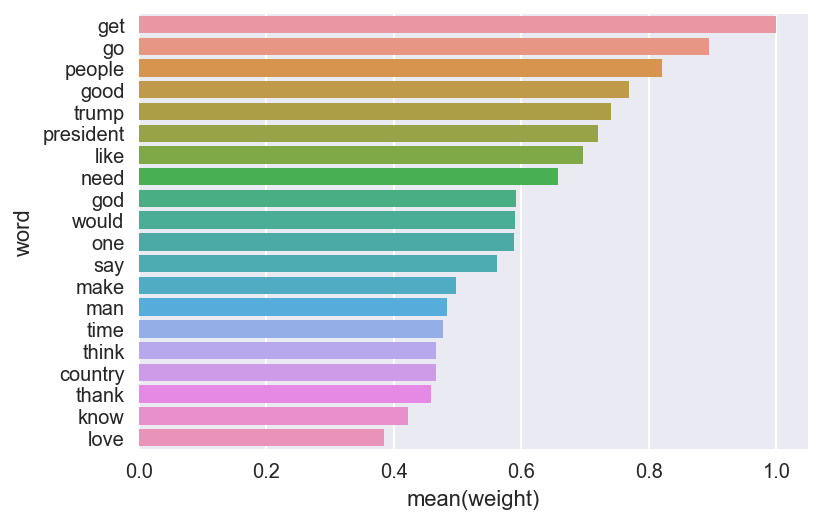

In [13]:
top_20_pos=common_words[['word','occurrences','weight']].sort_values(by='weight',ascending=False).head(20)
print(top_20_pos)
sbs.barplot(x='weight', y='word', data=top_20_pos);

In [14]:
words_dict=common_words[['word','weight']].apply(lambda x: {x['word']:x['weight']},axis=1)
words_dict=list(words_dict)
words_dict[0:3]

[{'get': 1.0}, {'go': 0.8945783132530121}, {'people': 0.8207831325301205}]

### Create the vectors

In [15]:
# Print the head of df
X=df.iloc[:,range(1,df.shape[1])]

In [16]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenizer,strip_accents ='unicode',min_df=10,ngram_range=(1,2))

dtm_tfidf = tfidf_vectorizer.fit_transform(X.clean_message)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

['abc', 'abide', 'ability', 'able', 'abortion', 'absolute', 'absolutely', 'abuse', 'accept', 'accomplish']


## Visualize the Clusters

#### Exploring the clusters

* After we create the topis Using the LDA algorithm, we are going to visualize it using the pyLDAvis library, which extracts information from a topic model and creates a web-based visualization where users can interactively explore the model 

* To understand what's going on we are going to label our data using LDA model with the number of the topic which has the best probability to match with the sentence. To do that we have created a function which will be apllied to the "clean_message" column row by row

* Also, we would like to do the same for the nmf cluster, so we are going to display the full text of the main docs for each topic, so we are going to create the display_topic() function

**References: **

*<https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/>*

*<https://nlpforhackers.io/topic-modeling/>*

*<https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730>*

*<https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d>*

*<https://github.com/bmabey/pyLDAvis>*

In [17]:
def get_cluster(model,vectorizer,text):
    x = model.transform(vectorizer.transform([text]))[0]
    for i in range(0,9):
        if(x[i]==x.max()):
            return(i)
        
def get_cluster_prob(model,vectorizer,text):
    x = model.transform(vectorizer.transform([text]))[0]
    return(x.max())

In [18]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [29]:
def most_similar(x, Z, top_n=5):
    dists = euclidean_distances(x.reshape(1, -1), Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar

def get_similars(X,text,model,vectorizer):
    x = nmf_model.transform(vectorizer.transform([text]))[0]
    similarities = most_similar(x, model)
    document_id, similarity = similarities[1]
    print(X[document_id])
    document_id, similarity = similarities[2]
    print(X[document_id])
    document_id, similarity = similarities[3]
    print(X[document_id])
    document_id, similarity = similarities[4]
    print(X[document_id])

In [61]:
no_topics =10

In [62]:
# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=50, learning_method='online', 
                                      learning_offset=50.,random_state=0).fit(dtm_tfidf)
lda   = lda_model.fit(dtm_tfidf)
lda_W = lda_model.transform(dtm_tfidf)
lda_H = lda_model.components_

In [63]:
pyLDAvis.sklearn.prepare(lda_model, dtm_tfidf, tfidf_vectorizer, mds='PCoA')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      45.363030        1       1 -0.072130  0.037224
3       9.639198        1       2 -0.224218  0.004032
0       7.906494        1       3 -0.175515 -0.252115
8       7.267331        1       4 -0.102135  0.209348
9       6.073316        1       5 -0.035744  0.050897
6       5.646729        1       6  0.012989 -0.012277
2       4.940635        1       7  0.085925  0.158411
4       4.424897        1       8  0.186620 -0.063629
7       4.399439        1       9  0.142621 -0.126070
1       4.338930        1      10  0.181587 -0.005822, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
703   Default  181.000000             god  181.000000  30.0000  30.0000
183   Default  130.000000           bless  130.000000  29.0000  29.0000
704   Default  115.000000       god bless  115.000000  28.0000  28.0000
969   Default   99.000000         liberal   99.000000  27.0000  27.0000
1104  Default   84.000000           money   84.000000  26.0000  26.0000
1757  Default  178.000000           thank  178.000000  25.0000  25.0000
1377  Default  183.000000       president  183.000000  24.0000  24.0000
733   Default  123.000000           great  123.000000  23.0000  23.0000
255   Default   82.000000            care   82.000000  22.0000  22.0000
1116  Default   76.000000              mr   76.000000  21.0000  21.0000
778   Default   72.000000            hell   72.000000  20.0000  20.0000
36    Default   71.000000           agree   71.000000  19.0000  19.0000
1793  Default  130.000000            time  130.000000  18.0000  18.0000
874   Default   70.000000            jail   70.000000  17.0000  17.0000
1829  Default  165.000000           trump  165.000000  16.0000  16.0000
1535  Default  135.000000             say  135.000000  15.0000  15.0000
1014  Default  137.000000            love  137.000000  14.0000  14.0000
1696  Default   96.000000          stupid   96.000000  13.0000  13.0000
1497  Default  112.000000           right  112.000000  12.0000  12.0000
1047  Default  145.000000             man  145.000000  11.0000  11.0000
689   Default  198.000000              go  198.000000  10.0000  10.0000
895   Default   53.000000           judge   53.000000   9.0000   9.0000
6     Default   51.000000      absolutely   51.000000   8.0000   8.0000
1125  Default   59.000000            much   59.000000   7.0000   7.0000
1170  Default   63.000000             nfl   63.000000   6.0000   6.0000
108   Default   74.000000             ass   74.000000   5.0000   5.0000
709   Default  211.000000            good  211.000000   4.0000   4.0000
1370  Default   50.000000          prayer   50.000000   3.0000   3.0000
604   Default   51.000000            fire   51.000000   2.0000   2.0000
1596  Default   50.000000            sick   50.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
1702  Topic10   11.306795          suffer   12.326987   3.0512  -4.7958
1071  Topic10   11.163015            meet   12.183188   3.0501  -4.8086
1301  Topic10   10.864935         penalty   11.885091   3.0478  -4.8356
581   Topic10   10.049695            fear   11.069879   3.0409  -4.9136
1862  Topic10    9.405437      university   10.425616   3.0346  -4.9799
1121  Topic10    8.887005       mrs trump    9.907124   3.0289  -5.0366
1511  Topic10    8.883499             rot    9.903652   3.0288  -5.0370
313   Topic10    8.828943            clue    9.849091   3.0282  -5.0431
1666  Topic10    8.811889           staff    9.832097   3.0280  -5.0451
1420  Topic10    8.719601            pure    9.739797   3.0269  -5.0556
1225  Topic10    8.695328         nursing    9.715452   3.0266  -5.0584
1740  Topic10    8.668310  taxpayer money    9.688446   3.0263  -5.0615
513   Topic10    8.533425     enforcement    9.553550   3.0246  -5.07

In [42]:
df['tfidf_cluster']=df.clean_message.apply(lambda x: get_cluster(model=lda_model,vectorizer=tfidf_vectorizer,text=x))
df['tfidf_cluster_prob']=df.clean_message.apply(lambda x: get_cluster_prob(model=lda_model,vectorizer=tfidf_vectorizer,text=x))

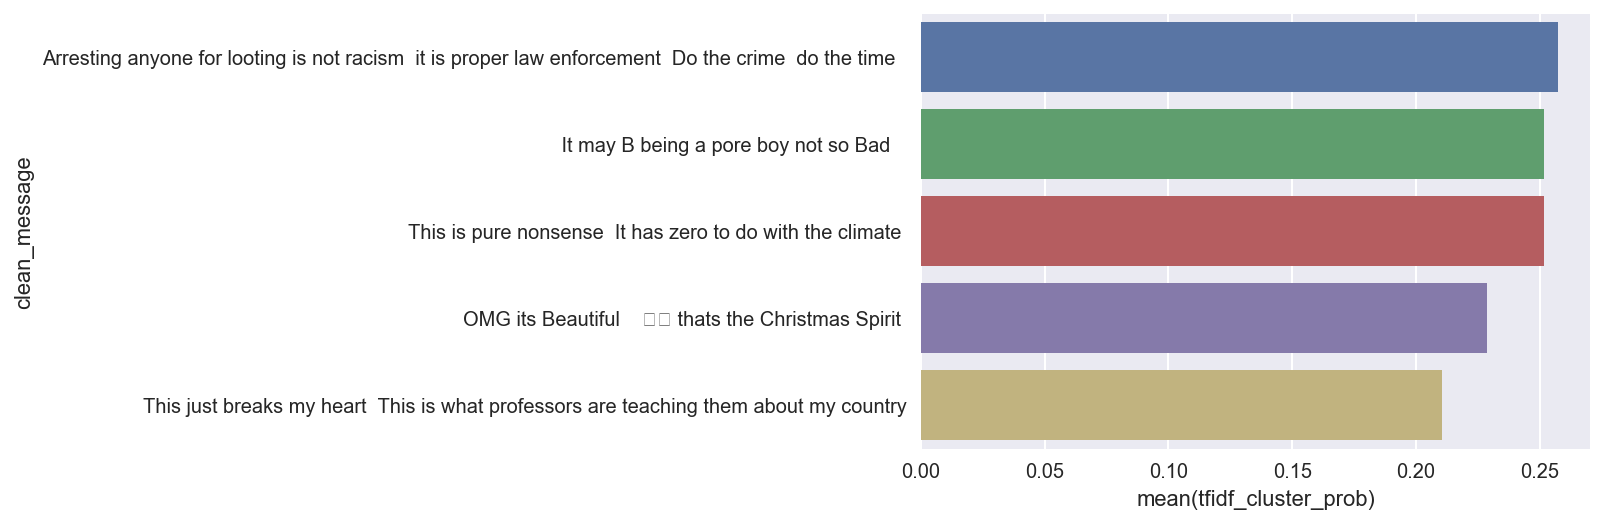

In [43]:
top_10_docs=df[df.tfidf_cluster==1][['clean_message','tfidf_cluster_prob']].sort_values(by='tfidf_cluster_prob',ascending=False).tail(5)
sbs.barplot(x='tfidf_cluster_prob', y='clean_message', data=top_10_docs);

In [28]:
df[df.tfidf_cluster==1].loc[983,'clean_message']

'Happy Birthday to all my Brothers and Sisters  Semper Fi'

In [44]:
df[(df.tfidf_cluster==0) & (df.tfidf_cluster_prob<1)][['clean_message','tfidf_cluster_prob']].sort_values(by='tfidf_cluster_prob',ascending=False).head(100)

,clean_message,tfidf_cluster_prob
7162,Thank God for President Trump God bless America,0.778334
6711,God bless you and your loving wife and family ...,0.772176
3066,Good for Tomi Lahren love her she has good old...,0.771219
6998,What a wise young man thank you God bless,0.771213
704,GOD BLESS OUR PRESIDENT TRUMP AND HIS WIFE AND...,0.770624
2811,God Bless America What a beautiful s...,0.770463
7070,Everything that needs to be said God Bles...,0.761197
7279,God bless you and God bless the United States ...,0.760644
7614,So beautiful God bless all who participated in...,0.751138
321,Ok Then God Bless America we that one,0.748928


In [45]:
df[df.tfidf_cluster==1].to_csv('df_tfidf_cluster.csv',sep=";",index=False)

In [46]:
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(dtm_tfidf)
nmf   = nmf_model.fit(dtm_tfidf)
nmf_W = nmf_model.transform(dtm_tfidf)
nmf_H = nmf_model.components_

In [47]:
text=df.clean_message[20]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=tfidf_vectorizer)

Need more parents like this mom👍
For once Rubio nailed it he needs to stand his ground on this issue for his Cuban heritage and his people   He really needs to tell Obama to stick it 
This is a HERO  Nothing more needs to be said 
YES DEFINITELY  WE NEED MORE JUDGES LIKE HIM 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
This interview was fabulous  Richard needs his own  independent   show to help bridge the gap  Right on


In [48]:
text=df.clean_message[1010]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=tfidf_vectorizer)

They love him  the art of the deal  is in his element  Bravo  Mr  PRESIDENT 
Love this   Merry Christmas Mr  President  FLOTUS  and Barron   Praying for you daily 
Love our President❤  truth speaker  unlike the lying media☹☹☹☹☹
Finally a President that will take action instead of giving them weapons to use against us  Love our President 🇺🇸🇺🇸
Check the facts   Our allies love this President   They recognize a real leader 


In [49]:
text=df.clean_message[2020]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=tfidf_vectorizer)

If true good Im glad        just hope he was tortured   suffered great pain
Good thise who do this must suffer great hurt mentally
Great looking pie   Keep me up the good work 😀😀😀
Ben Carson could do a good job in any job given This post of H U D  he has been there done that and would be Great in being the Secretary of H U D 
Great job mom  She wants her son to accept responsibility and become a good adult 


In [50]:
text=df.clean_message[12050]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=tfidf_vectorizer)

When is it going to end ssap I hope before he destroys whats left of america
I know where theres going to be a new parking lot   
Wow  That have continually been one of the NFLs biggest advertisers  Goodell is going down 
Keith you are having brake down go see a Dr idiot SHAME on you
He deserted   that means he quit  You try going back to a previous job to collect after you quit  If anything  his  back pay  should go towards medical bills or those injured looking for him   


In [51]:
display_topics(nmf_H, nmf_W, tfidf_vectorizer.get_feature_names(),X['clean_message'],10, 2)

Topic 0:
not like people would say think one know can can not
wasnt a hint it was factual
If you cant do the time dont COMITE the crime
Topic 1:
god bless god bless family bless president bless america america bless family thank god may god
This is heroism God bless you
God Bless you angel😇🎄🎁🎅
Topic 2:
president trump president trump mr mr president thank president bless president love president agree trump president
He is my president ☺Trump 💝
I Stand With President Trump 
Topic 3:
good job good job good luck luck good man hope keep work look
Good thats what   h  he dexerves
Or more importantly not good for Tesla profits 
Topic 4:
get get rid rid need get not get life let get life let get lose
GET THE WOODCHIPPER   
Get this fruit loop out of here
Topic 5:
man great young young man job great job proud good man smart great man
Man overboard         
That man is a stallion 
Topic 6:
thank thank god service thank service thank mr mr god thank president mr president sir
Thank you for not 